In [ ]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg       
import matplotlib.pyplot as plt        
import matplotlib.patches as mpatches 
from skimage import measure         
import scipy.ndimage as ndi  
from os.path import exists, join
from os import listdir
import sys

In [ ]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6) 

In [ ]:
image = mpimg.imread('sample_data/images/2.jpg')

In [ ]:
def Image(image_selection):
    if exists(image_selection):
        image_selection_filename = [f for f in listdir(image_selection)]
    else:
        massage = 'Some error occur'
        return print(massage)

def main():
    image_selection = input("Enter Your Image NO / Image Name : \n")
    Image(image_selection=image_selection)
    return

if __name__ == '__main__':
    main()

In [1]:
import os

images = os.join('sample_data/images')

AttributeError: module 'os' has no attribute 'join'

In [4]:
path = "/home"  
print(os.path.join(path, "/sample_data/images"))

/sample_data/images


In [ ]:
select_image = input(images)

In [ ]:
showimages = mpimg.imread(select_image)

In [ ]:
showimages

In [ ]:
showimages.transpose(2,0,1).reshape(3,-1)

In [ ]:
img = mpimg.imread(image)

cy, cx = ndi.center_of_mass(img)

plt.imshow(img, cmap='Set3')  
plt.scatter(cx, cy)           
plt.show()

In [1]:
import os
from skimage import io

In [2]:
def input_img (img_file):
    img_dir = 'sample_data/images'
    user_input = input('Enter file name')
    if os.path.exists(img_file):
        img = io.imread(img_file)
        return img
    else:
        return f'file not found'

Enter file name2.jpg


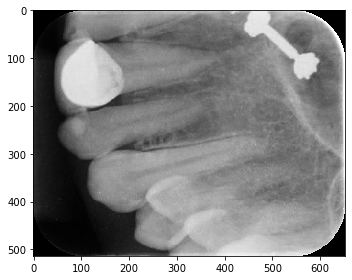

In [4]:
img_dir = 'sample_data/images'
user_input = input('Enter file name')

img_file_path = os.path.join(img_dir, user_input)
img = input_img(img_file_path)
io.imshow(img)